<a href="https://colab.research.google.com/github/gsfreitas/engenharia-medica/blob/main/atividade_pratica_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas e funções

In [ ]:
# importando as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import itertools
import scipy.io
import scipy.fft as fft
from scipy.signal import welch
from sklearn import svm
from scipy.stats import shapiro
import seaborn as sns
import operator

In [ ]:
def t6_perceptron(classe1, classe2, rho=0.05,maxsteps=10000):
    #Perceptron para duas classes
    #INPUTS:
    # - classe 1: L x N1 da primeira classe (características x padrões)
    # - classe 2: L x N2 da segunda classe (características x padrões)
    # - rho: learning parameter
    # - maxsteps = numero maximo de iteracoes
    #OUTPUT:
    # - ws: vetor com os pesos do classificador
    # - hs: indica se perceptron convergiu (1) ou não convergiu (0)
    # - t: número de iterações realizadas
    L1,N1=np.shape(classe1)
    L2,N2=np.shape(classe2)
    if L1!=L2:
        print('ERRO: Classes devem ter o mesmo número de características')
        return
    X=np.hstack((classe1, classe2))
    C=np.hstack((-np.ones(N1,),np.ones(N2,)))
    X=np.vstack((X,np.ones((1,N1+N2))))
    w=np.random.randn(L1+1,)
    ws=w;
    def classifica(w,X,C):
        res=np.sign(np.dot(w.T,X))
        Y=X[:,res*C<=0]
        CY=-C[res*C<=0]
        return Y, CY
    (Y,CY)=classifica(w,X,C)
    hs=np.shape(Y)[1]
    t=0
    while ((hs>0) & (t<maxsteps)):
        for i in range(L1+1):
            w[i]=w[i]-np.sum(rho*Y[i,:]*CY)
        [Y,CY]=classifica(w,X,C)
        t=t+1;
        ht=np.shape(Y)[1]
        if ht<hs:
            hs=ht
            ws=w
    if hs==0:
        print('Perceptron convergiu')
    else:
        print('Limite de interacoes atingido')
    return ws, hs, t

In [ ]:
def t6_plotaperceptron(classe1,classe2,w,titulo,angulo=(-140,40)):
    #Faz o gráfico do Perceptron (para 2 ou 3 características)
    # Inputs:
    # - classe 1: L x N1 da primeira classe (características x padrões)
    # - classe 2: L x N2 da segunda classe (características x padrões)
    # - w = vetor de pesos do perceptron
    # - titulo = string com o titulo do grafico
    # - angulo = angulo de visualização (para o caso de 3 características)
    L=np.size(w) #dimensão do Perceptron (estendida, ou seja = número de características + 1)
    if L==3:
        plt.figure()
        plt.plot(classe1[0,:],classe1[1,:],'bo',fillstyle='none')
        plt.plot(classe2[0,:],classe2[1,:],'ro',fillstyle='none')
        x1=plt.xlim()[0]
        x2=plt.xlim()[1]
        x=np.linspace(x1,x2,1000)
        y=-(w[0]*x+w[2])/w[1]
        plt.plot(x,y,'--')
        plt.title(titulo)
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')
        plt.show()
    elif L==4:
        plt.figure()
        ax=plt.axes(projection='3d')
        ax.plot(classe1[0,:],classe1[1,:],classe1[2,:],'bo',fillstyle='none')
        ax.plot(classe2[0,:],classe2[1,:],classe2[2,:],'ro',fillstyle='none')
        x=ax.get_xlim()
        y=ax.get_ylim()
        (xx,yy)=t8_makemeshgrid(np.asarray(x), np.asarray(y),0.01)
        z = (-w[0]*xx -w[1]*yy -w[3])/w[2];
        ax.plot_surface(xx,yy,z,edgecolor='none')
        ax.view_init(angulo[0],angulo[1])
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        plt.show()
    else:
        print('ERRO: apenas para 2 ou 3 dimensões')

In [ ]:
def t7_LS(classe1, classe2, c=0):
    #Classificador LS para duas classes.
    #INPUTS:
    # - classe 1: L x N1 da primeira classe
    # - classe 2: L x N2 da segunda classe
    # - c: parametro de regularidade (controla a singularidade da matriz de
    # correlacao)
    #OUTPUT:
    # - w: vetor com os pesos do classificador linear (ultimo elemento é o termo não
    # homogeneo)
    L1,N1=np.shape(classe1)
    L2,N2=np.shape(classe2)
    if L1!=L2:
        print('ERRO: Classes devem ter o mesmo número de características')
        return
    X=np.hstack((classe1, classe2))
    X=np.vstack((X,np.ones((1,N1+N2))))
    y=np.hstack((-np.ones(N1,),np.ones(N2,)))
    w=np.dot(np.linalg.inv(np.dot(X,X.T)+c*np.eye(L1+1)),np.dot(X,y));
    return w

In [ ]:
def t7_FDA(classes,n):
    # Encontra a transformação para o espaço da Analise Discriminante Linear de Fisher entre classes distintas
    # INPUT:
    # - classes: lista de classes. classes[i]= (L x Ni): L caracteristicas e Ni padroes na classe i
    # - n = numero de caracterisiticas para selecionar
    # OUTPUT:
    # - A: matriz de projecao (as colunas sao os vetores de projecao para o novo espaço)
    # - Lambda: autovalores
    C=len(classes)
    L=np.size(classes[0],axis=0)
    for i in range(C):
        if np.size(classes[i],axis=0)!=L:
            print('ERRO: Confira a dimensao das variaveis de input')
            return
    SW,SM,SB=t3_matrizesdeespalhamento(classes,range(L))
    (Lambda,Vec)=np.linalg.eig(np.dot(np.linalg.inv(SW),SB))
    s=Lambda.argsort()
    Lambda=Lambda[s[::-1]]#ordem decrescente
    Vec=Vec[:,s[::-1]]#ordem decrescente
    A=np.real(Vec[:,0:n])
    Lambda=Lambda[0:n]
    return A,Lambda

# Perceptron

**1) [Perceptron Pocket]**: No github do curso, você encontra uma função que implementa o classificador linear Perceptron para duas classes (“t6_perceptron” em “main.py”). A função recebe duas matrizes correspondendo a dados provenientes de duas classes distintas. As matrizes devem ter o mesmo número de características (L), mas podem ter números de padrões distintos. Além disso, a função recebe um número máximo de iterações e o parâmetro de aprendizagem do classificador (ρ). O algoritmo retorna o vetor em L+1 dimensões com os pesos do classificador linear.

**a)** Leia com calma a função para garantir que você compreende o que está sendo feito.

**b)** Agora vamos testá-la. No material de aula no Classroom você encontrará um arquivo chamado “dadosex1.mat” contendo cinco conjuntos de dados, “Classe1”, “Classe2a”, “Classe2b”, “Classe2c”, “Classe2d”. O primeiro conjunto corresponde aos dados da primeira classe e os demais conjuntos a 4 versões diferentes para os dados da segunda classe. Classe2a é o conjunto mais distante de Classe1. Classe2b e 2c são menos distantes, mas ainda linearmente separáveis da Classe 1. Por fim, Classe2d não é linearmente separável da Classe 1. Teste a velocidade do perceptron para a separação entre a classe 1 e a classe 2 para cada caso usando dois valores do parâmetro de aprendizagem ρ = 0 05 e ρ = 0.01. O que você pode concluir desses dados? Você consegue reproduzir figuras semelhantes com as figuras que estão a seguir? É claro que o plano do seu Perceptron poderá variar em relação às figuras abaixo. E note que há uma função pronta no material do curso para gerar os gráficos de um classificador linear qualquer em duas ou três dimensões (método “t6_plotaperceptron”). Use esta função para gerar os gráficos neste e nos demais problemas desta aula, se você assim preferir.

In [ ]:
# leitura dos dados
class_1 = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe1']
class_2a = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2a']
class_2b = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2b']
class_2c = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2c']
class_2d = scipy.io.loadmat("/content/drive/MyDrive/ict-unifesp/2023.2/engenharia-medica/atividade-pratica-7/dadosex1.mat")['Classe2d']

Perceptron convergiu


<Figure size 1200x500 with 0 Axes>

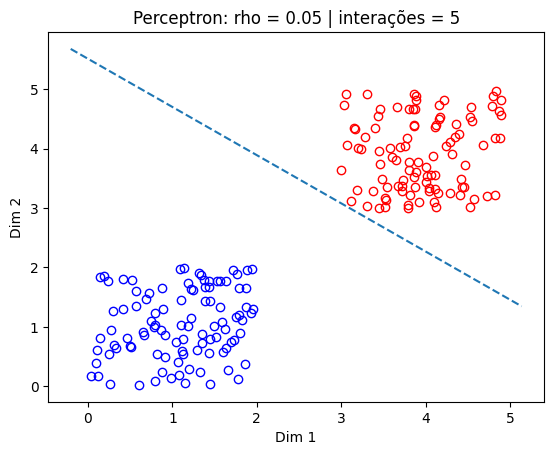

In [ ]:
# aplicacao do perceptron entre a classe 1 e variantes da classe 2
# testando com rho 0.05 e 0.01

ws_12a, hs_12a, t_12a = t6_perceptron(class_1, class_2a, rho=0.05,maxsteps=10000)

plt.figure(figsize=(12,5))
t6_plotaperceptron(class_1, class_2a, ws_12a, f"Perceptron: rho = 0.05 | interações = {t_12a}", angulo=(-140,40))